# Сверточные нейронные сети (ноутбук)

> Знакомимся со сверточными нейронными сетями. Учимся решать задачу классификации изображений.

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as T
from IPython.display import clear_output
from PIL import Image
from matplotlib import cm
from time import perf_counter
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from tqdm import tqdm

warnings.filterwarnings('ignore')

plt.rc('font', size=30)

## Загрузка изображения

Загрузим изображение из интернета, например, Питер Гриффина из одноименного мультсериала "Гриффины".

In [2]:
! wget "https://static.independent.co.uk/2021/10/29/14/newFile-8.jpg?width=1200" -O peter.jpg

--2022-05-16 21:05:15--  https://static.independent.co.uk/2021/10/29/14/newFile-8.jpg?width=1200
Resolving static.independent.co.uk (static.independent.co.uk)... 151.101.13.91
Connecting to static.independent.co.uk (static.independent.co.uk)|151.101.13.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 112326 (110K) [image/jpeg]
Saving to: ‘peter.jpg’

peter.jpg           100%[===================>] 109,69K  --.-KB/s    in 0,05s   

2022-05-16 21:05:15 (2,37 MB/s) - ‘peter.jpg’ saved [112326/112326]



## Чтение изображения

In [3]:
img = Image.open('peter.jpg')

In [4]:
img.format

'JPEG'

In [5]:
img.size

(1200, 899)

In [6]:
img.mode

'RGB'

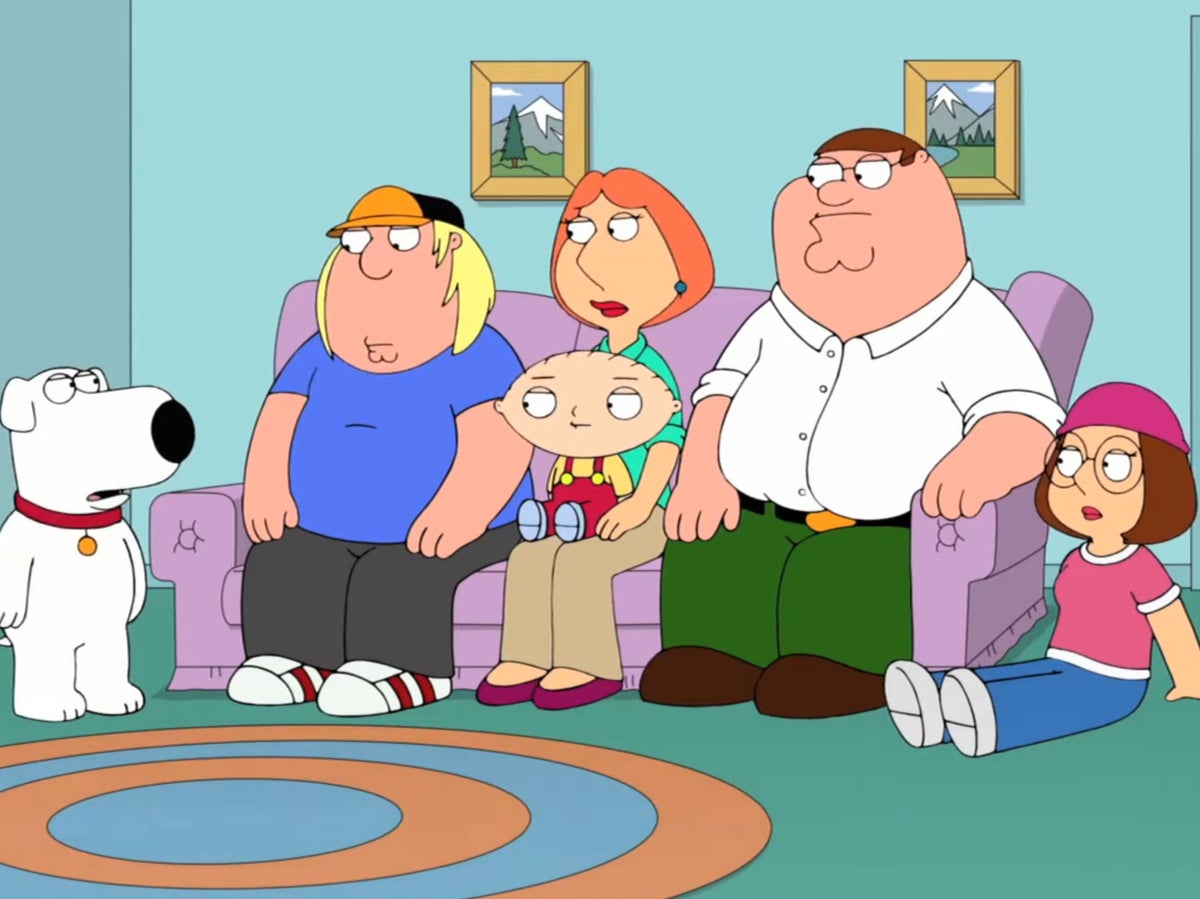

In [7]:
img

## Матричное представление

In [8]:
img_matrix = np.array(img)

In [9]:
img_matrix.shape

(899, 1200, 3)

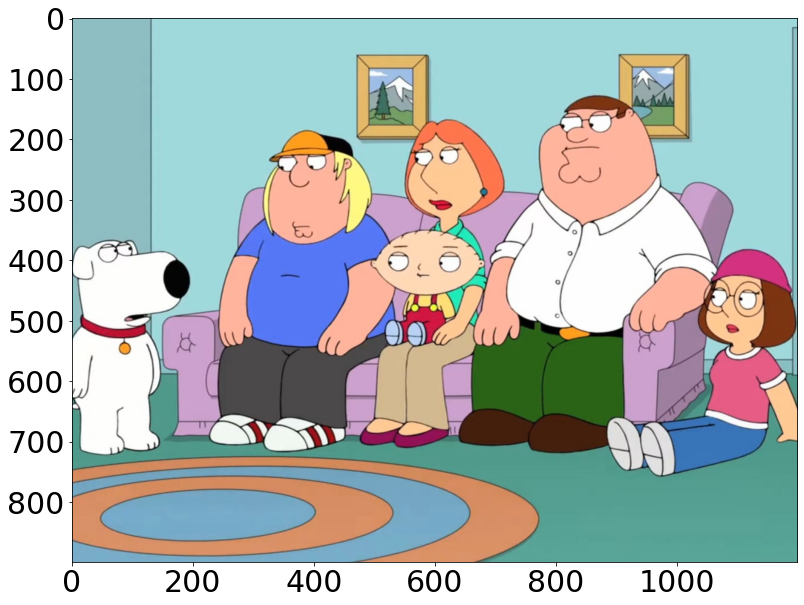

In [10]:
plt.figure(figsize=(20, 10))

plt.imshow(img_matrix)

plt.show()

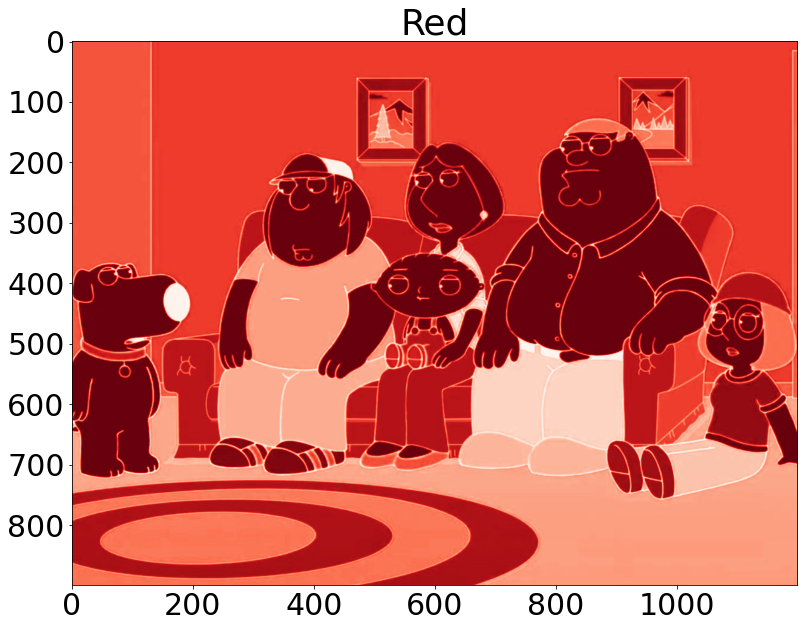

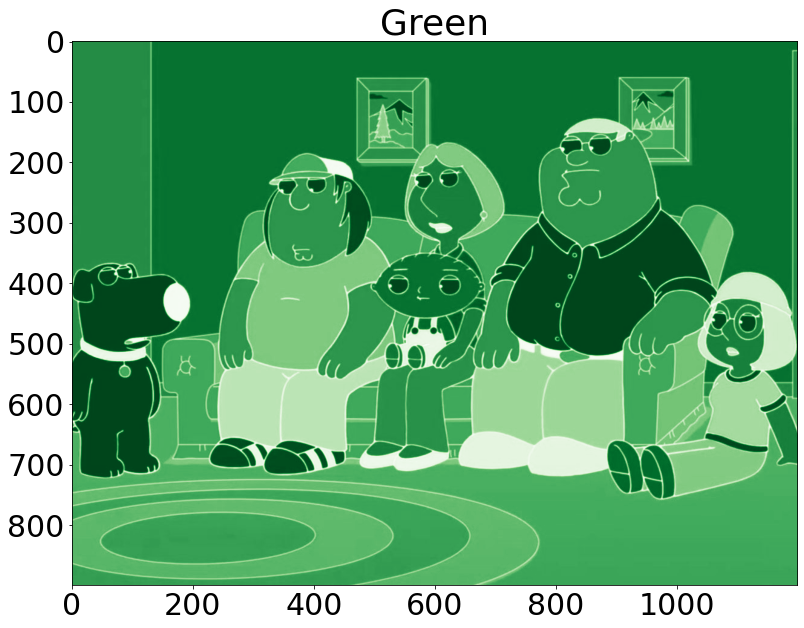

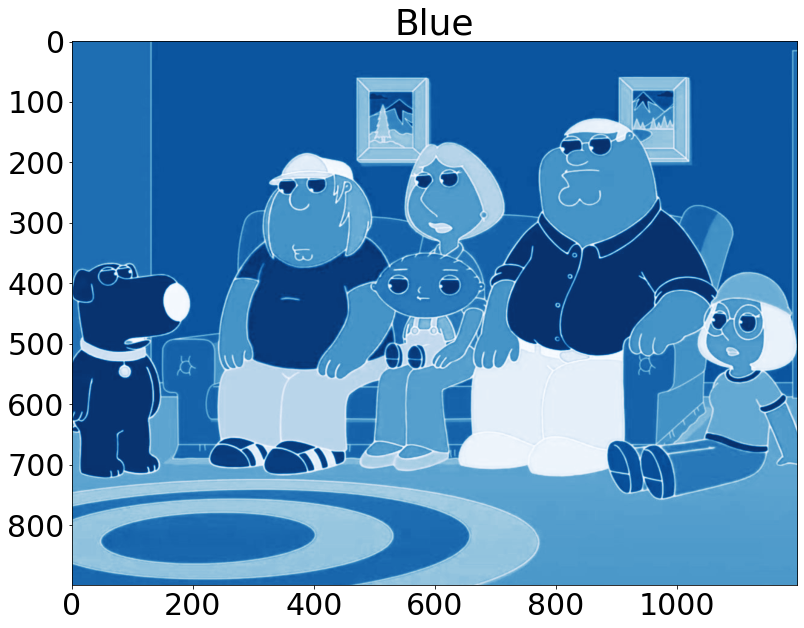

In [11]:
for i, (cmap, color) in enumerate(
    zip(
        [cm.Reds, cm.Greens, cm.Blues],
        ['Red', 'Green', 'Blue']
    )
):
    plt.figure(figsize=(20, 10))
    plt.imshow(img_matrix[:, :, i], cmap=cmap)
    plt.title(color)
    plt.show()

In [12]:
img_matrix[:, :, 0].min(), img_matrix[:, :, 0].max()

(0, 255)

In [13]:
img_matrix

array([[[142, 190, 194],
        [142, 190, 194],
        [142, 190, 194],
        ...,
        [157, 218, 219],
        [157, 218, 219],
        [157, 218, 219]],

       [[142, 190, 194],
        [142, 190, 194],
        [142, 190, 194],
        ...,
        [157, 218, 219],
        [157, 218, 219],
        [157, 218, 219]],

       [[142, 190, 194],
        [142, 190, 194],
        [142, 190, 194],
        ...,
        [158, 218, 219],
        [158, 218, 219],
        [158, 218, 219]],

       ...,

       [[121, 172, 201],
        [121, 172, 201],
        [121, 172, 201],
        ...,
        [ 91, 165, 152],
        [ 91, 165, 152],
        [ 91, 165, 152]],

       [[121, 172, 201],
        [121, 172, 201],
        [121, 172, 201],
        ...,
        [ 91, 165, 152],
        [ 91, 165, 152],
        [ 91, 165, 152]],

       [[121, 172, 201],
        [121, 172, 201],
        [121, 172, 201],
        ...,
        [ 91, 165, 152],
        [ 91, 165, 152],
        [ 91, 165, 152]]

## Свертка

Свертка в `PyTorch` представлена модулем `nn.Conv2d` со следующими параметрами:

- in_channels (int) – Количество каналов во входном изображении

- out_channels (int) – Количество каналов в выходном изображении

- kernel_size (int or tuple) – Размер ядра свертки

- stride (int or tuple, optional) – Страйд (шаг ядра свертки). По умолчанию: 1

- padding (int, tuple or str, optional) – Размер паддинга. По умолчанию: 0

- padding_mode (string, optional) – 'zeros', 'reflect', 'replicate' or 'circular'. По умолчанию: 'zeros'

- dilation (int or tuple, optional) – Дилейшн (шаг между элементами внутри ядра). По умолчанию: 1

- bias (bool, optional) – добавлять ли обучаемый сдвиг. По умолчанию: True

In [14]:
conv1 = nn.Conv2d(
    in_channels=3,
    out_channels=10,
    kernel_size=3
)

In [15]:
img_tensor = T.ToTensor()(img).unsqueeze(0)

In [16]:
img_tensor.shape

torch.Size([1, 3, 899, 1200])

In [17]:
output = conv1(img_tensor)

In [18]:
output.shape

torch.Size([1, 10, 897, 1198])

In [19]:
conv2 = nn.Conv2d(
    in_channels=3,
    out_channels=10,
    kernel_size=3,
    padding=1
)

In [20]:
output = conv2(img_tensor)

In [21]:
output.shape

torch.Size([1, 10, 899, 1200])

## Пулинг

Пулинг представлен в модуле `torch.nn`, в основном будем использовать `MaxPool2d` и `AvgPool2d`.

Параметры:

- kernel_size – размер окошка

- stride – страйд окошка. По умолчанию равен kernel_size

- padding – сколько нулевого паддинга добавлять по краям. По умолчанию: 0.

In [22]:
img_tensor = torch.randint(0, 10, size=(10, 10), dtype=torch.float32).unsqueeze(0)

In [23]:
img_tensor

tensor([[[1., 2., 8., 3., 9., 8., 9., 8., 2., 9.],
         [0., 4., 0., 2., 2., 0., 7., 9., 3., 2.],
         [2., 2., 1., 1., 8., 0., 8., 3., 6., 8.],
         [4., 8., 1., 9., 0., 6., 3., 6., 3., 7.],
         [4., 3., 7., 2., 7., 8., 6., 3., 0., 5.],
         [6., 2., 5., 3., 4., 2., 9., 2., 3., 8.],
         [3., 2., 8., 5., 5., 2., 4., 4., 8., 5.],
         [6., 4., 8., 3., 0., 6., 0., 4., 6., 9.],
         [1., 4., 2., 6., 8., 9., 7., 1., 4., 2.],
         [4., 1., 3., 3., 6., 3., 6., 7., 6., 0.]]])

In [24]:
pooling1 = nn.MaxPool2d(kernel_size=2)

In [25]:
pooling1(img_tensor)

tensor([[[4., 8., 9., 9., 9.],
         [8., 9., 8., 8., 8.],
         [6., 7., 8., 9., 8.],
         [6., 8., 6., 4., 9.],
         [4., 6., 9., 7., 6.]]])

In [26]:
pooling2 = nn.AvgPool2d(kernel_size=2)

In [27]:
pooling2(img_tensor)

tensor([[[1.7500, 3.2500, 4.7500, 8.2500, 4.0000],
         [4.0000, 3.0000, 3.5000, 5.0000, 6.0000],
         [3.7500, 4.2500, 5.2500, 5.0000, 4.0000],
         [3.7500, 6.0000, 3.2500, 3.0000, 7.0000],
         [2.5000, 3.5000, 6.5000, 5.2500, 3.0000]]])

## Датасет MNIST

In [28]:
mnist_train = MNIST(
    "../datasets/mnist",
    train=True,
    download=True
)

In [29]:
mnist_train[0]

(<PIL.Image.Image image mode=L size=28x28>, 5)

In [30]:
mnist_train[0][0]

In [31]:
mnist_train = MNIST(
    "../datasets/mnist",
    train=True,
    download=True,
    transform=T.ToTensor()
)

In [32]:
mnist_valid = MNIST(
    "../datasets/mnist",
    train=False,
    download=True,
    transform=T.ToTensor()
)

In [33]:
len(mnist_train)

60000

In [34]:
len(mnist_valid)

10000

In [35]:
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
valid_loader = DataLoader(mnist_valid, batch_size=64, shuffle=False)

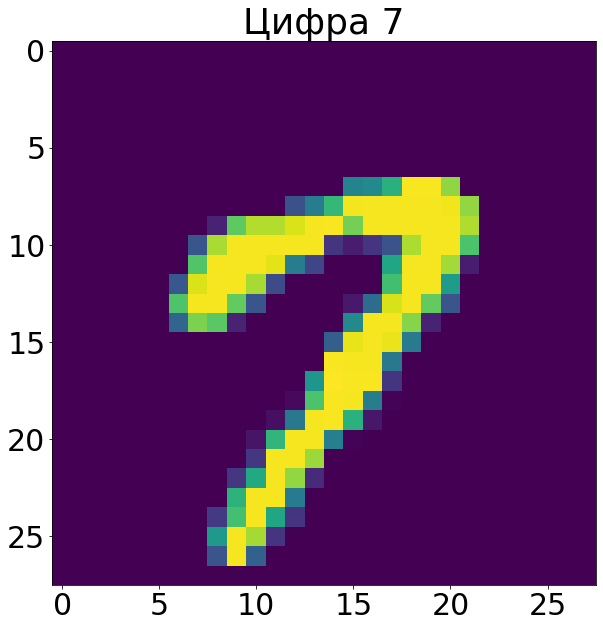

In [36]:
plt.figure(figsize=(10, 10))
plt.title(f'Цифра {mnist_train[15][1]}')
plt.imshow(mnist_train[15][0][0])

plt.show()

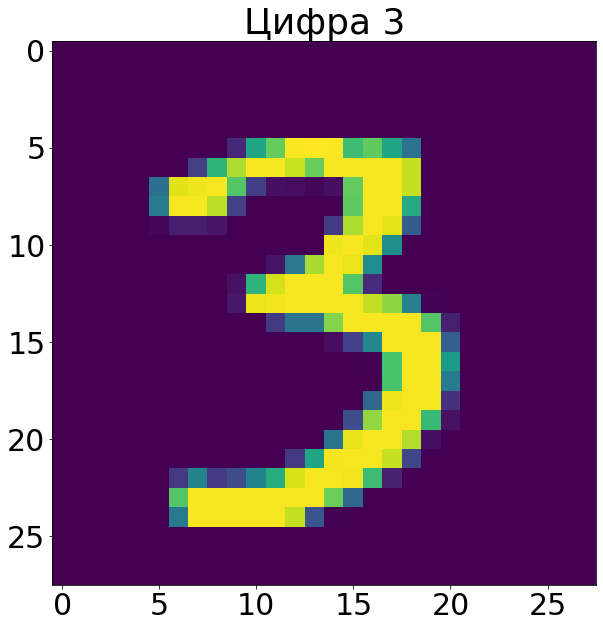

In [37]:
plt.figure(figsize=(10, 10))
plt.title(f'Цифра {mnist_train[10000][1]}')
plt.imshow(mnist_train[10000][0][0])

plt.show()

## Полносвязная нейронная сеть

Обучим полносвязную нейронную сеть на датасете MNIST.

In [38]:
def train(model: nn.Module) -> float:
    model.train()

    train_loss = 0

    for x, y in tqdm(train_loader, desc='Train'):
        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        train_loss += loss.item()

        loss.backward()

        optimizer.step()

    train_loss /= len(train_loader)
    
    return train_loss

In [39]:
@torch.inference_mode()
def evaluate(model: nn.Module, loader: DataLoader) -> tuple[float, float]:
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss, accuracy

In [40]:
def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    valid_accuracy: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')

    plt.plot(valid_accuracy)
    plt.grid()

    plt.show()

In [41]:
first_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)

optimizer = torch.optim.Adam(first_model.parameters(), lr=1e-3)

loss_fn = nn.CrossEntropyLoss()

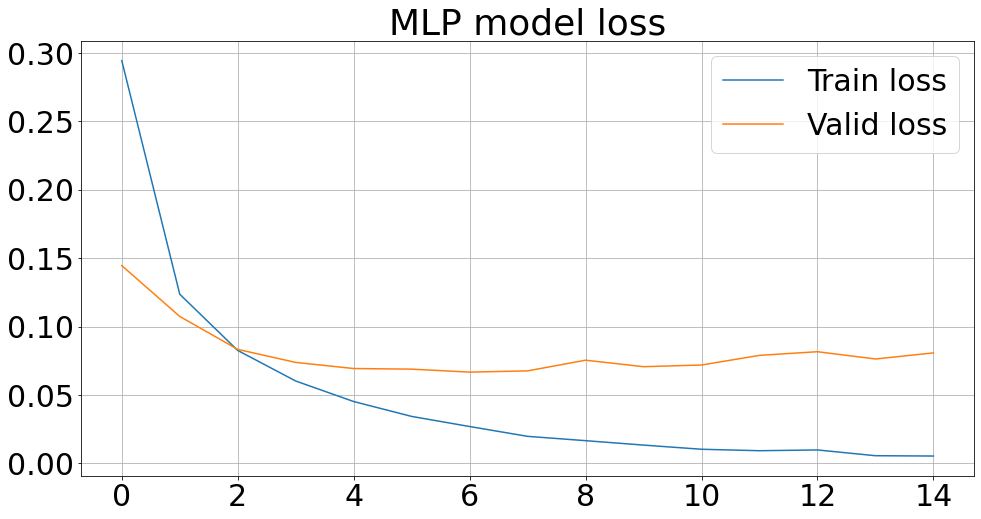

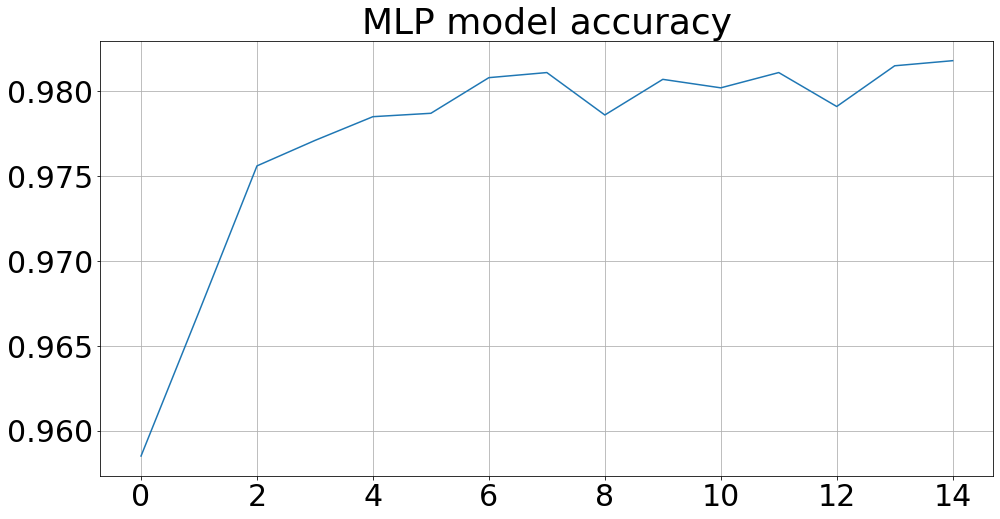

Total training and evaluation time 48.63823


In [42]:
num_epochs = 15

train_loss_history, valid_loss_history = [], []
valid_accuracy_history = []

start = perf_counter()

for epoch in range(num_epochs):
    train_loss = train(first_model)

    valid_loss, valid_accuracy = evaluate(first_model, valid_loader)

    train_loss_history.append(train_loss)
    valid_loss_history.append(valid_loss)
    valid_accuracy_history.append(valid_accuracy)
    
    clear_output()

    plot_stats(train_loss_history, valid_loss_history, valid_accuracy_history, 'MLP model')
    
print(f'Total training and evaluation time {perf_counter() - start:.5f}')

## Сверточная сеть

In [43]:
second_model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),

    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),

    nn.Flatten(),
    nn.Linear(4 * 4 * 64, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)

optimizer = torch.optim.Adam(second_model.parameters(), lr=1e-3)

loss_fn = nn.CrossEntropyLoss()

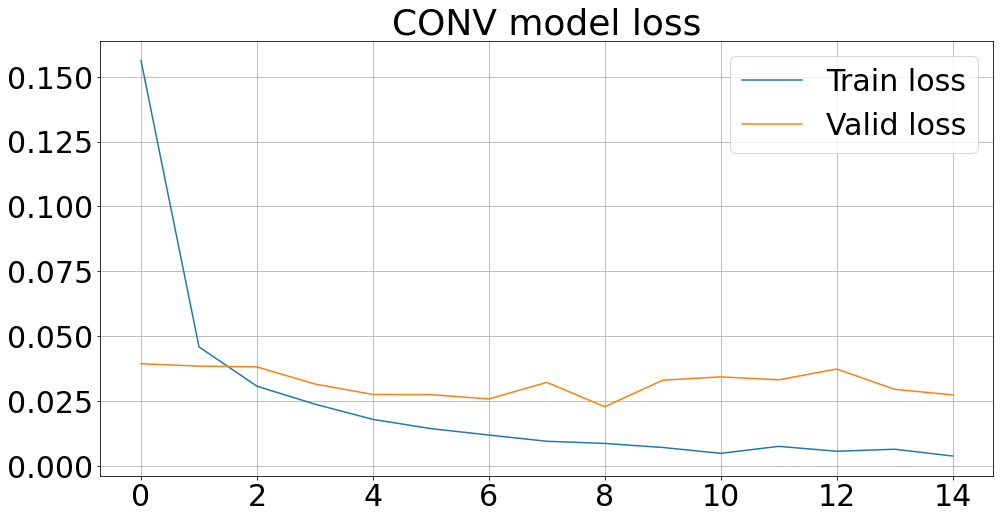

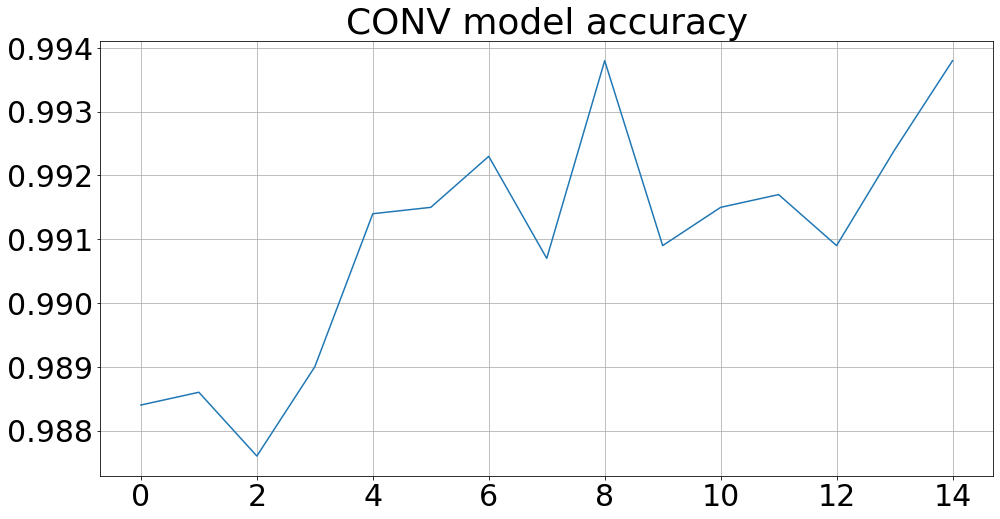

Total training and evaluation time 194.31792


In [44]:
num_epochs = 15

train_loss_history, valid_loss_history = [], []
valid_accuracy_history = []

start = perf_counter()

for epoch in range(num_epochs):
    train_loss = train(second_model)

    valid_loss, valid_accuracy = evaluate(second_model, valid_loader)

    train_loss_history.append(train_loss)
    valid_loss_history.append(valid_loss)
    valid_accuracy_history.append(valid_accuracy)

    clear_output()

    plot_stats(train_loss_history, valid_loss_history, valid_accuracy_history, 'CONV model')

print(f'Total training and evaluation time {perf_counter() - start:.5f}')